In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import LogRegAC.logRegAC as logRegAC
import LogRegAC.utilsAC as utilsAC
import LogRegAC.crossValdAC as crossValdAC

In [81]:
data = pd.read_csv('data.csv', header=None)
print(data.shape)
data.head()

(200, 3)


,0,1,2
0,6,32,1
1,26,39,1
2,2,38,1
3,25,39,1
4,3,35,1


In [82]:
data = data.sample(frac=1).reset_index(drop=True)
data_x = data.iloc[:, 0:-1]
data_y = data.iloc[:, -1].replace(-1, 0)

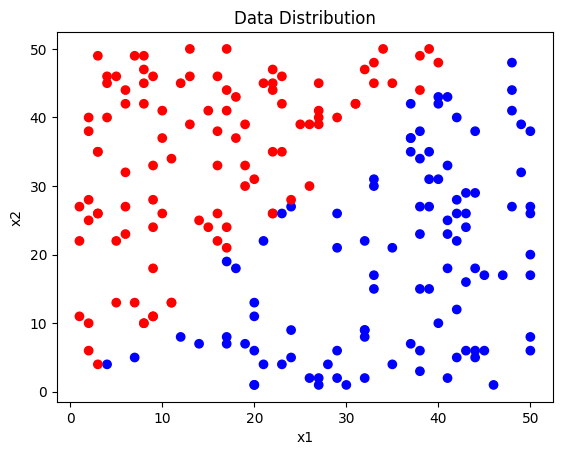

In [83]:
fig = plt.figure()
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Data Distribution')
plt.show()
fig.savefig('plots/data_dist.png')

In [84]:
train_x, train_y, test_x, test_y = utilsAC.splitTrainTest(data_x, data_y, 0.8)
train_x, train_min, train_max = utilsAC.normMinMax(train_x, mode='train')
test_x = utilsAC.normMinMax(test_x, mode='test', train_min=train_min, train_max=train_max)

## Newton's Method

In [85]:
nwt = logRegAC.LogReg(max_iter=100, eps=1e-5, newton=True)
t_beta = nwt.fit(train_x, train_y, iter_step=10, reg_term=1)
nwt_pred = nwt.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, nwt_pred)['f1'])

Implementing Newton's Method.
Iteration     0 | Cost:  136.657
Iteration    10 | Cost:  19.334
Iteration    20 | Cost:  14.991
Iteration    30 | Cost:  13.185
Iteration    40 | Cost:  12.111
Iteration    50 | Cost:  11.369
Iteration    60 | Cost:  10.812
Iteration    70 | Cost:  10.372
Iteration    80 | Cost:  10.010
Iteration    90 | Cost:  9.704
Iteration   100 | Cost:  9.440
F1 Score:  0.9743589743589743


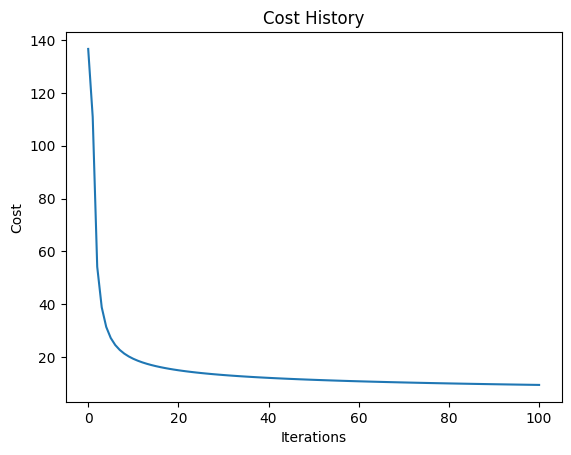

In [86]:
fig = plt.figure()
plt.plot(nwt.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/nwt_cost_hist.png')

In [87]:
nwt_trained_weights = nwt.get_params()
print(f'Trained Weights: {nwt_trained_weights}')
nwt_cf_info = utilsAC.get_performance_measure(data_y, nwt.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
nwt_cf_matrix = [[nwt_cf_info['tn'], nwt_cf_info['fn']], [nwt_cf_info['fp'], nwt_cf_info['tp']]]

Trained Weights: [[-32.41286503]
 [ 28.65838055]]


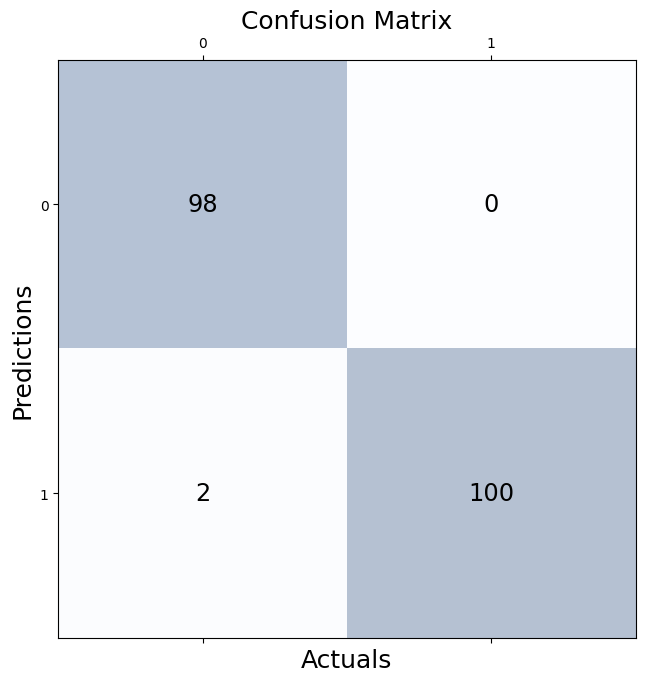

In [88]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(nwt_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(nwt_cf_matrix)):
    for j in range(len(nwt_cf_matrix[i])):
        ax.text(x=j, y=i,s=nwt_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/nwt_confusion_matrix.png')

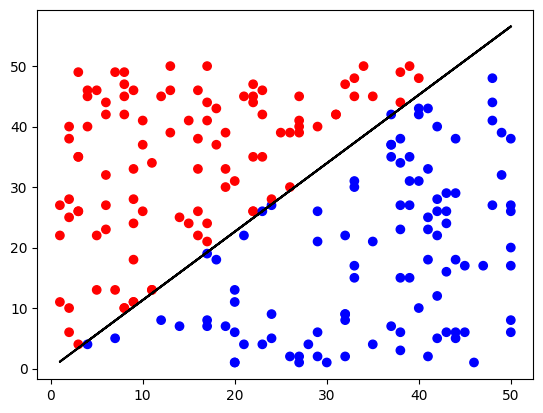

In [89]:
nwt_vals = np.dot(data_x, nwt_trained_weights).flatten()
nwt_plot_y = []
for i in range(len(nwt_vals)):
    nwt_plot_y.append((-nwt_trained_weights[0] * data_x.iloc[i, 0]) / nwt_trained_weights[1])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], nwt_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/nwt_data_dist_db.png')

## Using cross-validation Techniques

In [90]:
lrs = [0.01, 0.005, 0.003, 0.001]
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'violet', 'purple']

### Holdout Method with Batch Gradient Descent

In [91]:
hld_cv = crossValdAC.CrossVald(option='holdout')
gd_hld_train_costs, gd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.328
Iteration   200 | Cost:  25.106
Iteration   300 | Cost:  21.851
Iteration   400 | Cost:  19.873
Iteration   500 | Cost:  18.497
Iteration   600 | Cost:  17.461
Iteration   700 | Cost:  16.643
Iteration   800 | Cost:  15.972
Iteration   900 | Cost:  15.408
Iteration  1000 | Cost:  14.924
F1-score: 0.9841269841269841
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  43.278
Iteration   200 | Cost:  32.860
Iteration   300 | Cost:  28.069
Iteration   400 | Cost:  25.175
Iteration   500 | Cost:  23.180
Iteration   600 | Cost:  21.695
Iteration   700 | Cost:  20.530
Iteration   800 | Cost:  19.583
Iteration   900 | Cost:  18.792
Iteration  1000 | Cost:  18.118
F1-score: 0.9310344827586207
----------------- lr : 0.003 ---

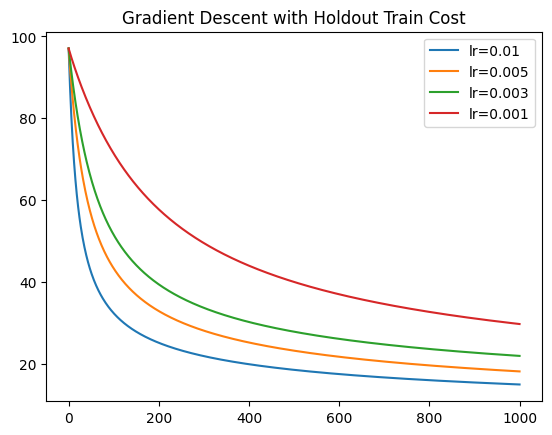

In [92]:
fig = plt.figure()
for i in range(len(gd_hld_train_costs)):
    plt.plot(gd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/gd_hld.png')

In [93]:
print(gd_hld_opt_model)

{'f1': 0.9259259259259259, 'lr': 0.001, 'w': array([[ 0.68570363],
       [-5.8073293 ],
       [ 4.33384026]])}


In [94]:
best_hld_gd = logRegAC.LogReg()
best_hld_gd.set_params(gd_hld_opt_model['w'])
hld_gd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_gd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_gd_cf_matrix = [[hld_gd_cf_info['tn'], hld_gd_cf_info['fn']], [hld_gd_cf_info['fp'], hld_gd_cf_info['tp']]]

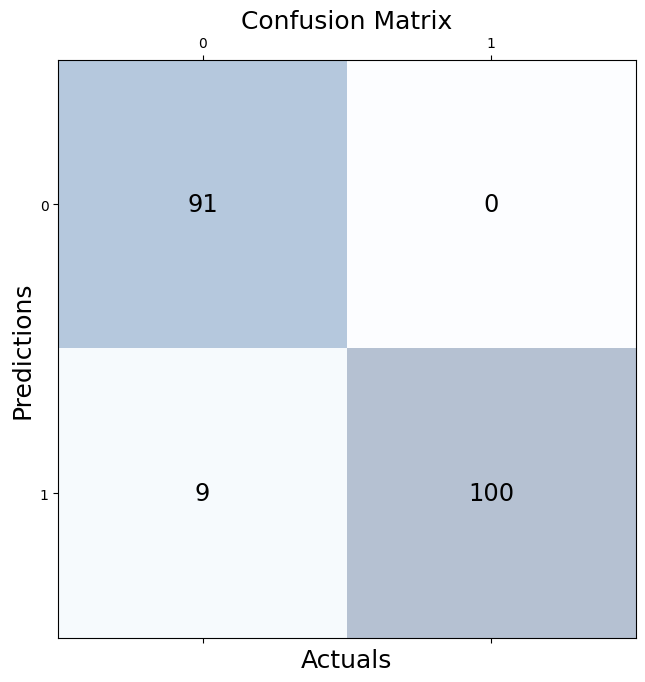

In [95]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_gd_cf_matrix)):
    for j in range(len(hld_gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_gd_confusion_matrix.png')

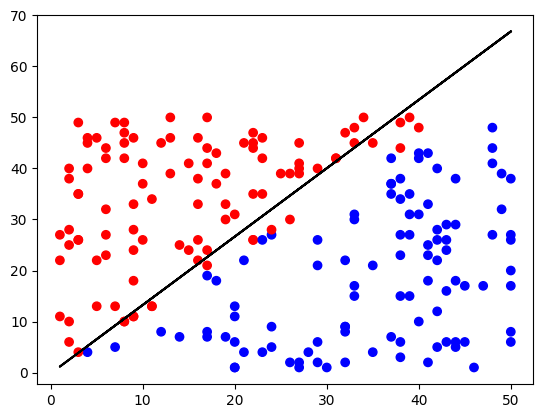

In [96]:
hld_gd_trained_weights = gd_hld_opt_model['w']
hld_gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(hld_gd_vals)):
    gd_plot_y.append(-(hld_gd_trained_weights[0] + (hld_gd_trained_weights[1] * data_x.iloc[i, 0])) / hld_gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_gd_data_dist_db.png')

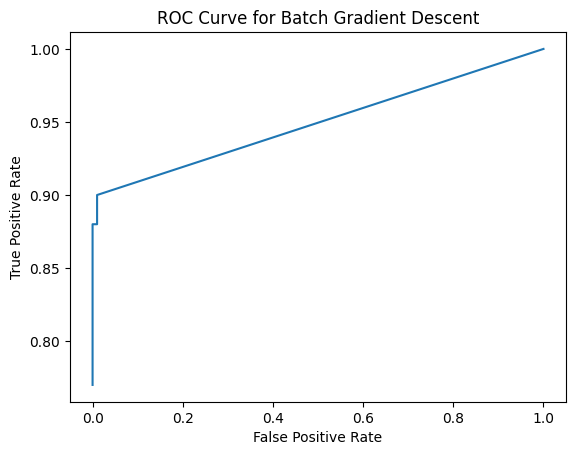

In [97]:
hld_gd_pred_prob = best_hld_gd.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in hld_gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_gd_roc.png')

### Holdout Method with Stochastic Gradient Descent

In [98]:
sgd_hld_train_costs, sgd_hld_opt_model = hld_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Holdout Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.166
Iteration   200 | Cost:  25.040
Iteration   300 | Cost:  21.868
Iteration   400 | Cost:  19.958
Iteration   500 | Cost:  18.639
Iteration   600 | Cost:  17.653
Iteration   700 | Cost:  16.878
Iteration   800 | Cost:  16.246
Iteration   900 | Cost:  15.717
Iteration  1000 | Cost:  15.266
F1-score: 0.9655172413793104
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  44.240
Iteration   200 | Cost:  33.950
Iteration   300 | Cost:  29.252
Iteration   400 | Cost:  26.435
Iteration   500 | Cost:  24.506
Iteration   600 | Cost:  23.076
Iteration   700 | Cost:  21.960
Iteration   800 | Cost:  21.055
Iteration   900 | Cost:  20.302
Iteration  1000 | Cost:  19.662
F1-score: 0.983050847457627
----------------- lr : 

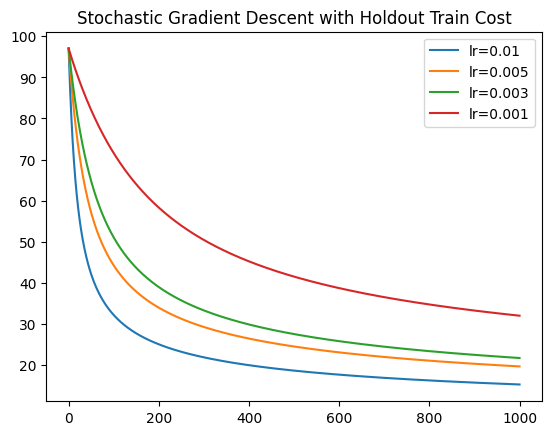

In [99]:
fig = plt.figure()
for i in range(len(sgd_hld_train_costs)):
    plt.plot(sgd_hld_train_costs[i], label=f'lr={lrs[i]}')
plt.legend()
plt.title('Stochastic Gradient Descent with Holdout Train Cost')
plt.show()
fig.savefig('plots/sgd_hld.png')

In [100]:
print(sgd_hld_opt_model)

{'f1': 0.9655172413793104, 'lr': 0.01, 'w': array([[  1.09510643],
       [-14.26281353],
       [ 11.19235056]])}


In [101]:
best_hld_sgd = logRegAC.LogReg()
best_hld_sgd.set_params(sgd_hld_opt_model['w'])
hld_sgd_cf_info = utilsAC.get_performance_measure(data_y, best_hld_sgd.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
hld_sgd_cf_matrix = [[hld_sgd_cf_info['tn'], hld_sgd_cf_info['fn']], [hld_sgd_cf_info['fp'], hld_sgd_cf_info['tp']]]

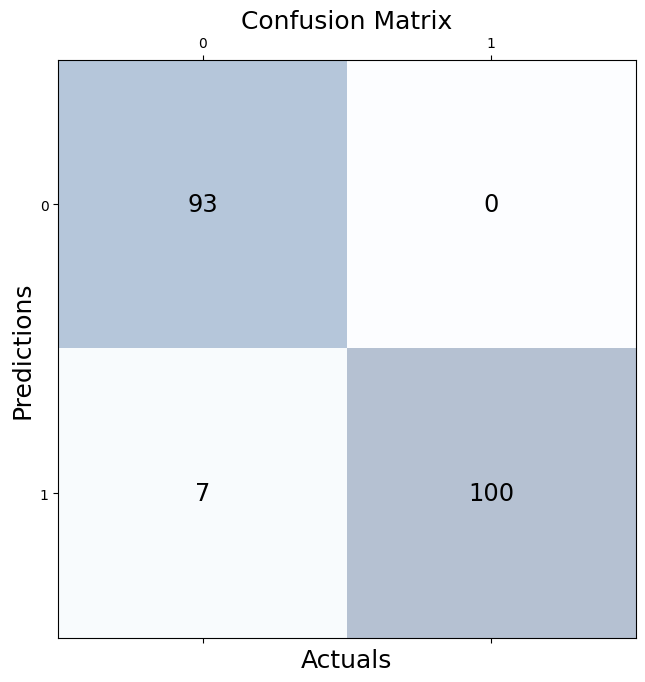

In [102]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(hld_sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(hld_sgd_cf_matrix)):
    for j in range(len(hld_sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=hld_sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/hld_sgd_confusion_matrix.png')

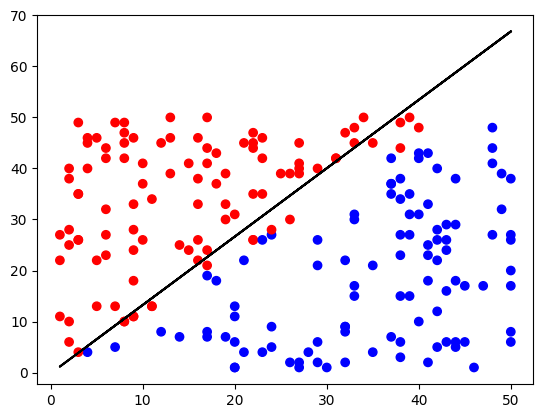

In [103]:
hld_sgd_trained_weights = sgd_hld_opt_model['w']
hld_sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], hld_sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(hld_gd_vals)):
    sgd_plot_y.append(-(hld_sgd_trained_weights[0] + (hld_sgd_trained_weights[1] * data_x.iloc[i, 0])) / hld_sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/hld_sgd_data_dist_db.png')

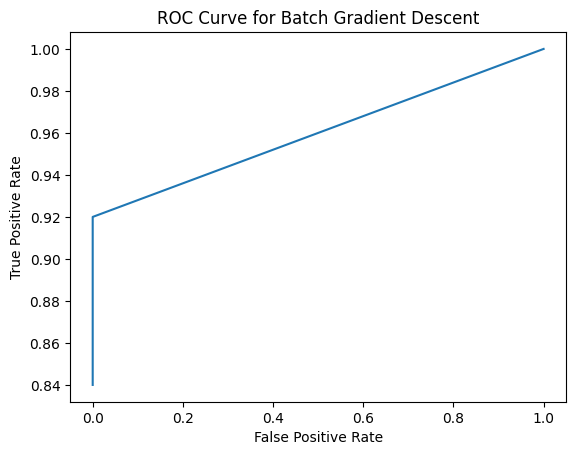

In [104]:
hld_sgd_pred_prob = best_hld_sgd.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in hld_sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/hld_sgd_roc.png')

### Monte Carlo Cross-Validation with Batch Gradient Descent

In [105]:
montc_cv = crossValdAC.CrossVald(option='monte_carlo', monte_carlo=5)
gd_montc_train_costs, gd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.464
Iteration   200 | Cost:  25.400
Iteration   300 | Cost:  22.225
Iteration   400 | Cost:  20.298
Iteration   500 | Cost:  18.958
Iteration   600 | Cost:  17.952
Iteration   700 | Cost:  17.157
Iteration   800 | Cost:  16.507
Iteration   900 | Cost:  15.961
Iteration  1000 | Cost:  15.493
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.015
Iteration   200 | Cost:  24.677
Iteration   300 | Cost:  21.423
Iteration   400 | Cost:  19.481
Iteration   500 | Cost:  18.151
Iteration   600 | Cost:  17.166
Iteration   700 | Cost:  16.397
Iteration   800 | Cost:  15.774
Iteration   900 | Cost:  15.256
Iteration  1000 | Cost:  14.816
F1-score: 0.9850746268656716
----------------- lr : 0.01 ----------------

In [106]:
print(gd_montc_opt_model)

{'f1': 0.9487974479410697, 'lr': 0.003, 'w': array([[ 0.69041569],
       [-9.05654058],
       [ 7.32232881]])}


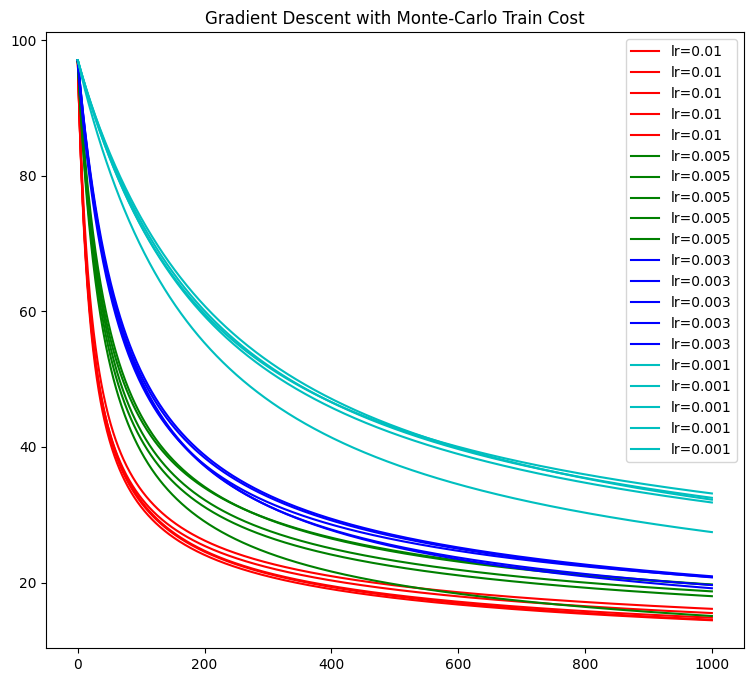

In [107]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_montc_train_costs)):
    for j in range(len(gd_montc_train_costs[i])):
        plt.plot(gd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/gd_montc.png')

### Monte Carlo Cross-Validation with Stochastic Gradient Descent

In [108]:
sgd_montc_train_costs, sgd_montc_opt_model = montc_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing Monte Carlo Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  32.865
Iteration   200 | Cost:  25.002
Iteration   300 | Cost:  21.498
Iteration   400 | Cost:  19.401
Iteration   500 | Cost:  17.962
Iteration   600 | Cost:  16.894
Iteration   700 | Cost:  16.059
Iteration   800 | Cost:  15.382
Iteration   900 | Cost:  14.818
Iteration  1000 | Cost:  14.338
F1-score: 0.9655172413793104
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  97.041
Iteration   100 | Cost:  31.736
Iteration   200 | Cost:  24.650
Iteration   300 | Cost:  21.464
Iteration   400 | Cost:  19.525
Iteration   500 | Cost:  18.172
Iteration   600 | Cost:  17.151
Iteration   700 | Cost:  16.341
Iteration   800 | Cost:  15.676
Iteration   900 | Cost:  15.115
Iteration  1000 | Cost:  14.632
F1-score: 0.9824561403508771
----------------- l

In [109]:
print(sgd_montc_opt_model)

{'f1': 0.9494645194426494, 'lr': 0.001, 'w': array([[ 0.7873886 ],
       [-5.68005039],
       [ 4.26389398]])}


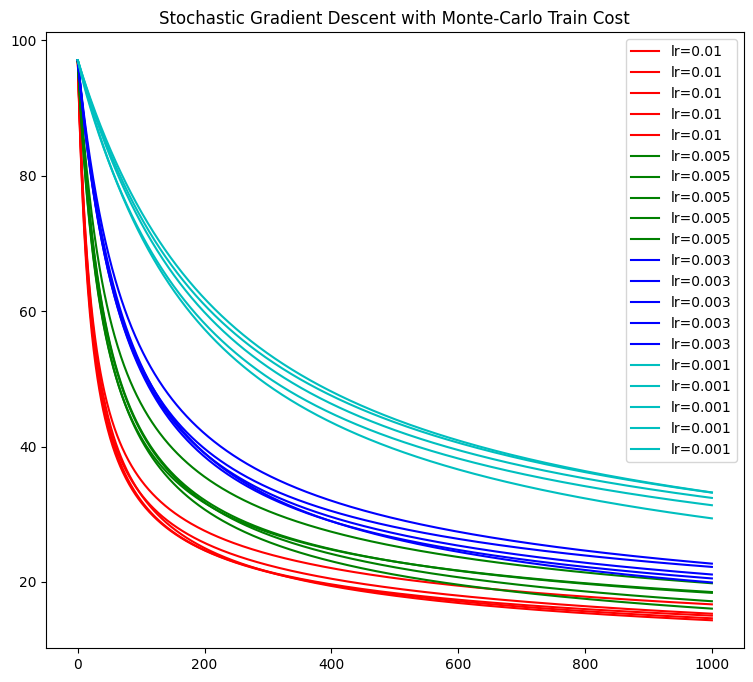

In [110]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_montc_train_costs)):
    for j in range(len(sgd_montc_train_costs[i])):
        plt.plot(sgd_montc_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with Monte-Carlo Train Cost')
plt.show()
fig.savefig('plots/sgd_montc.png')

In [111]:
kfold_cv = crossValdAC.CrossVald(option='k_fold', k_fold=6)
gd_kfold_train_costs, gd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  32.677
Iteration   200 | Cost:  24.856
Iteration   300 | Cost:  21.391
Iteration   400 | Cost:  19.308
Iteration   500 | Cost:  17.873
Iteration   600 | Cost:  16.802
Iteration   700 | Cost:  15.960
Iteration   800 | Cost:  15.276
Iteration   900 | Cost:  14.703
Iteration  1000 | Cost:  14.214
F1-score: 0.8571428571428571
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.857
Iteration   200 | Cost:  28.932
Iteration   300 | Cost:  25.326
Iteration   400 | Cost:  23.123
Iteration   500 | Cost:  21.588
Iteration   600 | Cost:  20.434
Iteration   700 | Cost:  19.522
Iteration   800 | Cost:  18.776
Iteration   900 | Cost:  18.150
Iteration  1000 | Cost:  17.614
F1-score: 1.0
----------------- lr : 0.01 -----------------
I

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  17.956
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  34.620
Iteration   200 | Cost:  26.547
Iteration   300 | Cost:  22.942
Iteration   400 | Cost:  20.764
Iteration   500 | Cost:  19.256
Iteration   600 | Cost:  18.126
Iteration   700 | Cost:  17.235
Iteration   800 | Cost:  16.508
Iteration   900 | Cost:  15.898
Iteration  1000 | Cost:  15.375
F1-score: 0.9375
----------------- lr : 0.01 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  33.847
Iteration   200 | Cost:  26.195
Iteration   300 | Cost:  22.791
Iteration   400 | Cost:  20.741
Iteration   500 | Cost:  19.328
Iteration   600 | Cost:  18.273
Iteration   700 | Cost:  17.444
Iteration   800 | Cost:  16.771
Iteration   900 | Cost:  16.208
Iteration  1000 | Cost:  15.728
F1-score: 1.0
----------------- lr : 0.005 -----------------
Impl

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  19.689
F1-score: 0.9375
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.864
Iteration   200 | Cost:  36.112
Iteration   300 | Cost:  31.290
Iteration   400 | Cost:  28.395
Iteration   500 | Cost:  26.400
Iteration   600 | Cost:  24.911
Iteration   700 | Cost:  23.740
Iteration   800 | Cost:  22.785
Iteration   900 | Cost:  21.985
Iteration  1000 | Cost:  21.301
F1-score: 0.9655172413793104
----------------- lr : 0.005 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.211
Iteration   200 | Cost:  35.864
Iteration   300 | Cost:  30.729
Iteration   400 | Cost:  27.636
Iteration   500 | Cost:  25.504
Iteration   600 | Cost:  23.913
Iteration   700 | Cost:  22.664
Iteration   800 | Cost:  21.648
Iteration   900 | Cost:  20.799
Iteration  1000 | Cost:  20.074
F1-score: 0.967741935483871
----------------- lr

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration   100 | Cost:  56.409
Iteration   200 | Cost:  42.595
Iteration   300 | Cost:  36.177
Iteration   400 | Cost:  32.322
Iteration   500 | Cost:  29.685
Iteration   600 | Cost:  27.736
Iteration   700 | Cost:  26.217
Iteration   800 | Cost:  24.990
Iteration   900 | Cost:  23.970
Iteration  1000 | Cost:  23.104
F1-score: 0.9500000000000001
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  59.679
Iteration   200 | Cost:  46.017
Iteration   300 | Cost:  39.604
Iteration   400 | Cost:  35.728
Iteration   500 | Cost:  33.065
Iteration   600 | Cost:  31.087
Iteration   700 | Cost:  29.541
Iteration   800 | Cost:  28.288
Iteration   900 | Cost:  27.243
Iteration  1000 | Cost:  26.353
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.812
Iteration   200 | Cost:  44.383
Iteration   300 | C

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  25.606
F1-score: 0.9565217391304348
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  54.088
Iteration   200 | Cost:  40.071
Iteration   300 | Cost:  33.662
Iteration   400 | Cost:  29.860
Iteration   500 | Cost:  27.287
Iteration   600 | Cost:  25.400
Iteration   700 | Cost:  23.941
Iteration   800 | Cost:  22.769
Iteration   900 | Cost:  21.801
Iteration  1000 | Cost:  20.982
F1-score: 0.9444444444444444
----------------- lr : 0.003 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  114.369
Iteration   100 | Cost:  55.996
Iteration   200 | Cost:  41.775
Iteration   300 | Cost:  35.163
Iteration   400 | Cost:  31.212
Iteration   500 | Cost:  28.527
Iteration   600 | Cost:  26.555
Iteration   700 | Cost:  25.030
Iteration   800 | Cost:  23.805
Iteration   900 | Cost:  22.793
Iteration  1000 | Cost:  21.939
F1-score: 0.8823529411764706
-------

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclud

Iteration  1000 | Cost:  37.829
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.223
Iteration   200 | Cost:  65.694
Iteration   300 | Cost:  56.138
Iteration   400 | Cost:  49.908
Iteration   500 | Cost:  45.496
Iteration   600 | Cost:  42.185
Iteration   700 | Cost:  39.592
Iteration   800 | Cost:  37.496
Iteration   900 | Cost:  35.758
Iteration  1000 | Cost:  34.289
F1-score: 0.9333333333333333
----------------- lr : 0.001 -----------------
Implementing Batch Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.779
Iteration   200 | Cost:  66.628
Iteration   300 | Cost:  57.272
Iteration   400 | Cost:  51.154
Iteration   500 | Cost:  46.811
Iteration   600 | Cost:  43.543
Iteration   700 | Cost:  40.979
Iteration   800 | Cost:  38.903
Iteration   900 | Cost:  37.179
Iteration  1000 | Cost:  35.718
F1-score: 1.0
----------------- lr : 

/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)
/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


In [112]:
print(gd_kfold_opt_model)

{'f1': 0.9553824635020544, 'lr': 0.001, 'w': array([[ 0.6141911 ],
       [-6.32470299],
       [ 4.5773949 ]])}


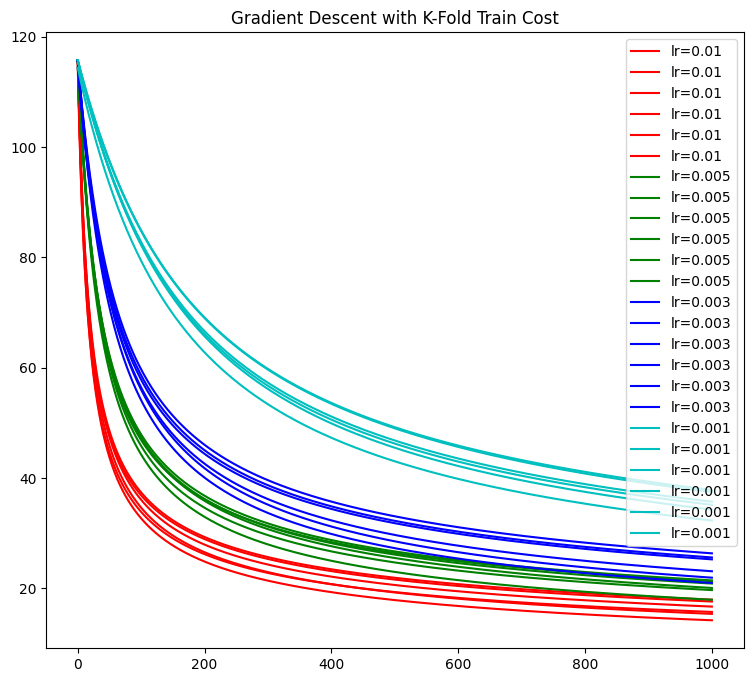

In [113]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(gd_kfold_train_costs)):
    for j in range(len(gd_kfold_train_costs[i])):
        plt.plot(gd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/gd_kfold.png')

In [114]:
sgd_kfold_train_costs, sgd_kfold_opt_model = kfold_cv.fit(data_x, data_y, lr=lrs, max_iter=1000, iter_step=100, eps=1e-5, stochGD=True)

Implementing K-Fold Cross Validation.
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.837
Iteration   200 | Cost:  27.611


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  23.921
Iteration   400 | Cost:  21.689
Iteration   500 | Cost:  20.144
Iteration   600 | Cost:  18.986
Iteration   700 | Cost:  18.075
Iteration   800 | Cost:  17.331
Iteration   900 | Cost:  16.707
Iteration  1000 | Cost:  16.174
F1-score: 0.9090909090909091
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.048


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.275
Iteration   300 | Cost:  23.806
Iteration   400 | Cost:  21.709
Iteration   500 | Cost:  20.256
Iteration   600 | Cost:  19.167
Iteration   700 | Cost:  18.308
Iteration   800 | Cost:  17.606
Iteration   900 | Cost:  17.017
Iteration  1000 | Cost:  16.513
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  34.249
Iteration   200 | Cost:  26.493
Iteration   300 | Cost:  23.030
Iteration   400 | Cost:  20.929
Iteration   500 | Cost:  19.467
Iteration   600 | Cost:  18.366
Iteration   700 | Cost:  17.494
Iteration   800 | Cost:  16.780
Iteration   900 | Cost:  16.179
Iteration  1000 | Cost:  15.663
F1-score: 0.9032258064516129
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  35.027
Iteration   200 | Cost:  27.380


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  23.997
Iteration   400 | Cost:  21.961
Iteration   500 | Cost:  20.554
Iteration   600 | Cost:  19.501
Iteration   700 | Cost:  18.673
Iteration   800 | Cost:  17.996
Iteration   900 | Cost:  17.429
Iteration  1000 | Cost:  16.944
F1-score: 1.0
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  36.126


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  27.798
Iteration   300 | Cost:  24.109
Iteration   400 | Cost:  21.896
Iteration   500 | Cost:  20.374
Iteration   600 | Cost:  19.241
Iteration   700 | Cost:  18.353
Iteration   800 | Cost:  17.632
Iteration   900 | Cost:  17.030
Iteration  1000 | Cost:  16.518
F1-score: 0.9767441860465117
----------------- lr : 0.01 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  36.193
Iteration   200 | Cost:  27.963
Iteration   300 | Cost:  24.226
Iteration   400 | Cost:  21.949
Iteration   500 | Cost:  20.366
Iteration   600 | Cost:  19.179
Iteration   700 | Cost:  18.243
Iteration   800 | Cost:  17.480
Iteration   900 | Cost:  16.841
Iteration  1000 | Cost:  16.295
F1-score: 0.9714285714285714
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  44.817
Iteration   200 | Cost:  33.382


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  28.306
Iteration   400 | Cost:  25.299
Iteration   500 | Cost:  23.254
Iteration   600 | Cost:  21.746
Iteration   700 | Cost:  20.573
Iteration   800 | Cost:  19.625
Iteration   900 | Cost:  18.839
Iteration  1000 | Cost:  18.171
F1-score: 0.9375
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.336


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  36.029
Iteration   300 | Cost:  30.978
Iteration   400 | Cost:  27.959
Iteration   500 | Cost:  25.888
Iteration   600 | Cost:  24.349
Iteration   700 | Cost:  23.142
Iteration   800 | Cost:  22.162
Iteration   900 | Cost:  21.343
Iteration  1000 | Cost:  20.644
F1-score: 0.9411764705882353
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  47.161
Iteration   200 | Cost:  36.163
Iteration   300 | Cost:  31.186
Iteration   400 | Cost:  28.190
Iteration   500 | Cost:  26.127
Iteration   600 | Cost:  24.589
Iteration   700 | Cost:  23.383
Iteration   800 | Cost:  22.401
Iteration   900 | Cost:  21.581
Iteration  1000 | Cost:  20.880
F1-score: 0.9696969696969697
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  46.732
Iteration   200 | Cost:  35.329


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  30.254
Iteration   400 | Cost:  27.237
Iteration   500 | Cost:  25.179
Iteration   600 | Cost:  23.658
Iteration   700 | Cost:  22.472
Iteration   800 | Cost:  21.512
Iteration   900 | Cost:  20.714
Iteration  1000 | Cost:  20.037
F1-score: 0.967741935483871
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  47.759


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  36.895
Iteration   300 | Cost:  31.975
Iteration   400 | Cost:  29.001
Iteration   500 | Cost:  26.943
Iteration   600 | Cost:  25.402
Iteration   700 | Cost:  24.187
Iteration   800 | Cost:  23.195
Iteration   900 | Cost:  22.363
Iteration  1000 | Cost:  21.650
F1-score: 0.9696969696969697
----------------- lr : 0.005 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  45.918
Iteration   200 | Cost:  34.874
Iteration   300 | Cost:  29.951
Iteration   400 | Cost:  27.017
Iteration   500 | Cost:  25.009
Iteration   600 | Cost:  23.518
Iteration   700 | Cost:  22.351
Iteration   800 | Cost:  21.403
Iteration   900 | Cost:  20.612
Iteration  1000 | Cost:  19.938
F1-score: 0.9523809523809523
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.988
Iteration   200 | Cost:  43.835


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  37.207
Iteration   400 | Cost:  33.214
Iteration   500 | Cost:  30.476
Iteration   600 | Cost:  28.449
Iteration   700 | Cost:  26.867
Iteration   800 | Cost:  25.587
Iteration   900 | Cost:  24.523
Iteration  1000 | Cost:  23.618
F1-score: 0.9545454545454545
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  55.433


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  42.125
Iteration   300 | Cost:  36.032
Iteration   400 | Cost:  32.388
Iteration   500 | Cost:  29.898
Iteration   600 | Cost:  28.056
Iteration   700 | Cost:  26.620
Iteration   800 | Cost:  25.457
Iteration   900 | Cost:  24.489
Iteration  1000 | Cost:  23.666
F1-score: 1.0
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  58.784
Iteration   200 | Cost:  44.968
Iteration   300 | Cost:  38.518
Iteration   400 | Cost:  34.634
Iteration   500 | Cost:  31.969
Iteration   600 | Cost:  29.992
Iteration   700 | Cost:  28.446
Iteration   800 | Cost:  27.192
Iteration   900 | Cost:  26.148
Iteration  1000 | Cost:  25.258
F1-score: 0.9655172413793104
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  58.364
Iteration   200 | Cost:  44.258


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  37.636
Iteration   400 | Cost:  33.643
Iteration   500 | Cost:  30.906
Iteration   600 | Cost:  28.881
Iteration   700 | Cost:  27.302
Iteration   800 | Cost:  26.026
Iteration   900 | Cost:  24.966
Iteration  1000 | Cost:  24.066
F1-score: 0.9500000000000001
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  57.114


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  43.368
Iteration   300 | Cost:  36.999
Iteration   400 | Cost:  33.191
Iteration   500 | Cost:  30.598
Iteration   600 | Cost:  28.688
Iteration   700 | Cost:  27.206
Iteration   800 | Cost:  26.011
Iteration   900 | Cost:  25.021
Iteration  1000 | Cost:  24.182
F1-score: 0.9090909090909091
----------------- lr : 0.003 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  55.479
Iteration   200 | Cost:  41.644
Iteration   300 | Cost:  35.281
Iteration   400 | Cost:  31.491
Iteration   500 | Cost:  28.915
Iteration   600 | Cost:  27.019
Iteration   700 | Cost:  25.549
Iteration   800 | Cost:  24.363
Iteration   900 | Cost:  23.380
Iteration  1000 | Cost:  22.548
F1-score: 0.972972972972973
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.480
Iteration   200 | Cost:  67.224


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  57.687
Iteration   400 | Cost:  51.403
Iteration   500 | Cost:  46.916
Iteration   600 | Cost:  43.524
Iteration   700 | Cost:  40.854
Iteration   800 | Cost:  38.683
Iteration   900 | Cost:  36.876
Iteration  1000 | Cost:  35.342
F1-score: 0.923076923076923
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  82.908


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  66.735
Iteration   300 | Cost:  57.381
Iteration   400 | Cost:  51.271
Iteration   500 | Cost:  46.934
Iteration   600 | Cost:  43.670
Iteration   700 | Cost:  41.108
Iteration   800 | Cost:  39.031
Iteration   900 | Cost:  37.305
Iteration  1000 | Cost:  35.841
F1-score: 0.9375
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  82.390
Iteration   200 | Cost:  65.967
Iteration   300 | Cost:  56.491
Iteration   400 | Cost:  50.325
Iteration   500 | Cost:  45.966
Iteration   600 | Cost:  42.698
Iteration   700 | Cost:  40.142
Iteration   800 | Cost:  38.076
Iteration   900 | Cost:  36.364
Iteration  1000 | Cost:  34.916
F1-score: 0.962962962962963
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.371
Iteration   200 | Cost:  67.299


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   300 | Cost:  57.948
Iteration   400 | Cost:  51.821
Iteration   500 | Cost:  47.465
Iteration   600 | Cost:  44.186
Iteration   700 | Cost:  41.612
Iteration   800 | Cost:  39.526
Iteration   900 | Cost:  37.793
Iteration  1000 | Cost:  36.325
F1-score: 0.9411764705882353
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  115.756
Iteration   100 | Cost:  83.952


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   200 | Cost:  67.965
Iteration   300 | Cost:  58.593
Iteration   400 | Cost:  52.419
Iteration   500 | Cost:  48.011
Iteration   600 | Cost:  44.681
Iteration   700 | Cost:  42.059
Iteration   800 | Cost:  39.930
Iteration   900 | Cost:  38.158
Iteration  1000 | Cost:  36.655
F1-score: 0.967741935483871
----------------- lr : 0.001 -----------------
Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  114.369


/Users/abinashchetia/Desktop/log_reg_ac/LogRegAC/crossValdAC.py:93: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_y = pd.concat([train_y, data_folds[j].iloc[:, -1]], axis=0)


Iteration   100 | Cost:  80.733
Iteration   200 | Cost:  64.368
Iteration   300 | Cost:  54.938
Iteration   400 | Cost:  48.802
Iteration   500 | Cost:  44.462
Iteration   600 | Cost:  41.208
Iteration   700 | Cost:  38.661
Iteration   800 | Cost:  36.603
Iteration   900 | Cost:  34.898
Iteration  1000 | Cost:  33.456
F1-score: 0.9767441860465117


In [115]:
print(sgd_kfold_opt_model)

{'f1': 0.9515337463597507, 'lr': 0.001, 'w': array([[ 0.41392265],
       [-6.18537587],
       [ 4.77264301]])}


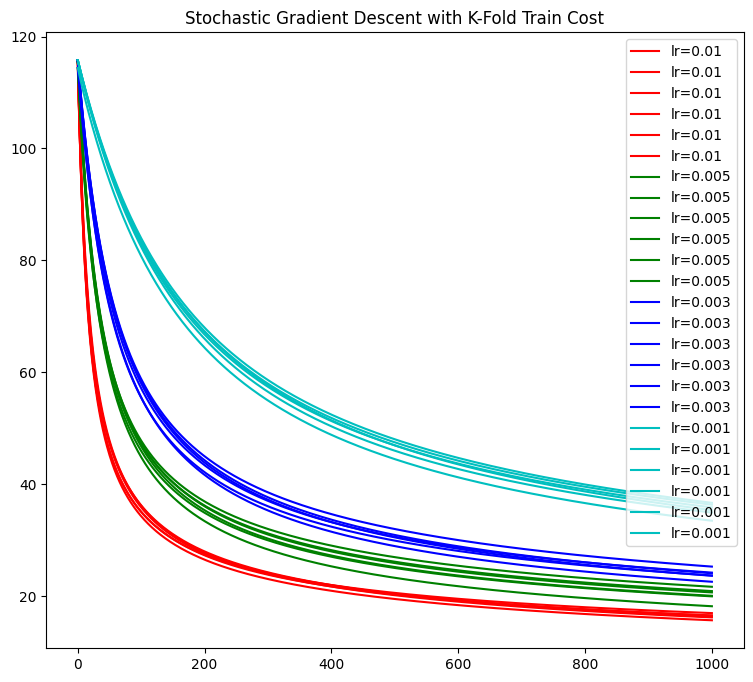

In [116]:
fig = plt.figure(figsize=(9, 8))
for i in range(len(sgd_kfold_train_costs)):
    for j in range(len(sgd_kfold_train_costs[i])):
        plt.plot(sgd_kfold_train_costs[i][j], label=f'lr={lrs[i]}', color=colors[i])
plt.legend()
plt.title('Stochastic Gradient Descent with K-Fold Train Cost')
plt.show()
fig.savefig('plots/sgd_kfold.png')

## Batch Gradient Descent

In [117]:
logReg1 = logRegAC.LogReg(lr=0.01, max_iter=1000)
logReg1.fit(train_x, train_y, iter_step=100)
pred = logReg1.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred)['f1'])

Implementing Batch Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.750
Iteration   200 | Cost:  27.033
Iteration   300 | Cost:  23.533
Iteration   400 | Cost:  21.391
Iteration   500 | Cost:  19.893
Iteration   600 | Cost:  18.762
Iteration   700 | Cost:  17.866
Iteration   800 | Cost:  17.130
Iteration   900 | Cost:  16.511
Iteration  1000 | Cost:  15.980
F1 Score:  0.9743589743589743


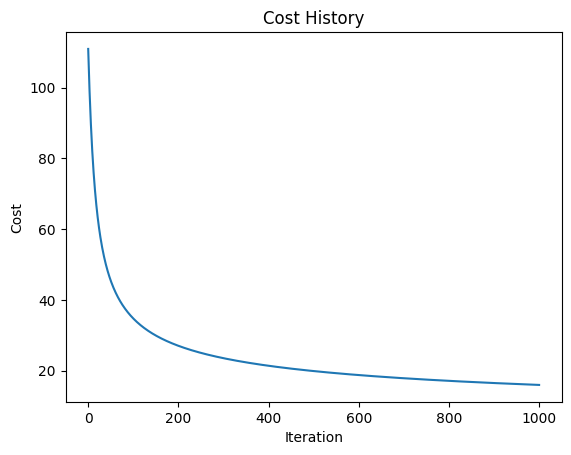

In [118]:
fig = plt.figure()
plt.plot(logReg1.get_cost_hist())
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/gd_cost_hist.png')

In [119]:
gd_trained_weights = logReg1.get_params()
print(f'Trained Weights: {gd_trained_weights}')
gd_cf_info = utilsAC.get_performance_measure(data_y, logReg1.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
gd_cf_matrix = [[gd_cf_info['tn'], gd_cf_info['fn']], [gd_cf_info['fp'], gd_cf_info['tp']]]

Trained Weights: [[  1.11830665]
 [-15.2873956 ]
 [ 11.81585511]]


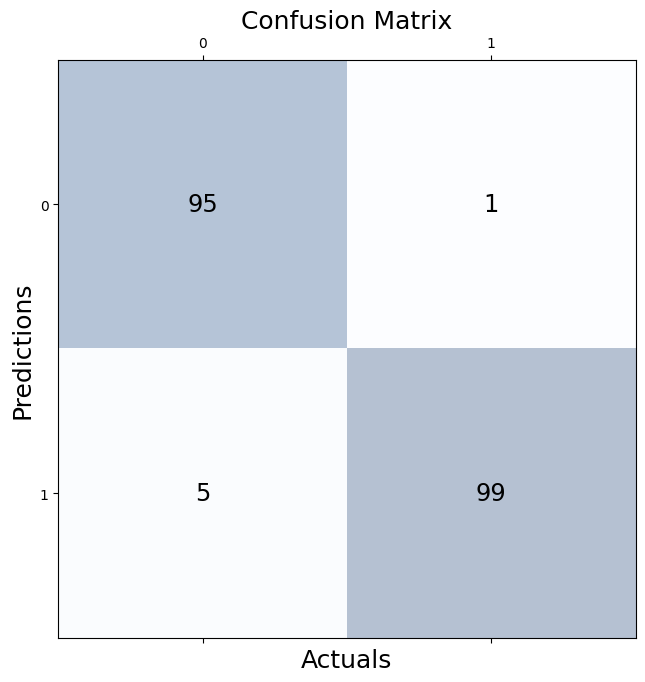

In [120]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(gd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(gd_cf_matrix)):
    for j in range(len(gd_cf_matrix[i])):
        ax.text(x=j, y=i,s=gd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/gd_confusion_matrix.png')

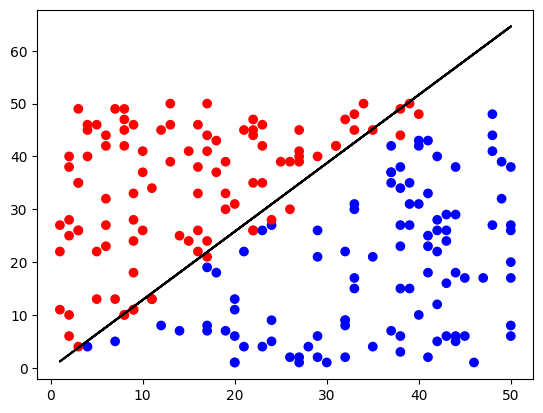

In [121]:
gd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], gd_trained_weights).flatten()
gd_plot_y = []
for i in range(len(gd_vals)):
    gd_plot_y.append(-(gd_trained_weights[0] + (gd_trained_weights[1] * data_x.iloc[i, 0])) / gd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], gd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/gd_data_dist_db.png')

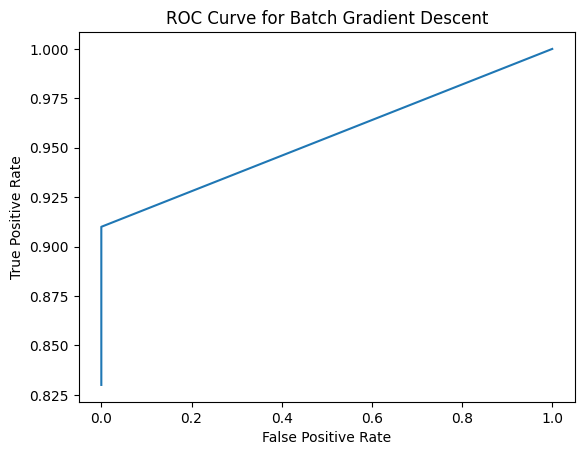

In [122]:
gd_pred_prob = logReg1.predict(data_x, prob=True)
thresh = np.arange(0, 1, 0.001)
gd_tpr = []
gd_fpr = []
for t in thresh:
    gd_pred = [1 if i >= t else 0 for i in gd_pred_prob]
    gd_cf_info = utilsAC.get_performance_measure(data_y, gd_pred)
    tp = gd_cf_info['tp']
    fp = gd_cf_info['fp']
    tn = gd_cf_info['tn']
    fn = gd_cf_info['fn']
    gd_tpr.append(tp/(tp+fn))
    gd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Batch Gradient Descent')
plt.show()
fig.savefig('plots/gd_roc.png')

## Stochastic Gradient Descent

In [123]:
logReg2 = logRegAC.LogReg(lr=0.01, max_iter=1000, stochGD=True)
logReg2.fit(train_x, train_y, iter_step=100)
pred2 = logReg2.predict(test_x)
print('F1 Score: ', utilsAC.get_performance_measure(test_y, pred2)['f1'])

Implementing Stochastic Gradient Descent.
Iteration     0 | Cost:  110.904
Iteration   100 | Cost:  34.859
Iteration   200 | Cost:  27.082
Iteration   300 | Cost:  23.562
Iteration   400 | Cost:  21.411
Iteration   500 | Cost:  19.907
Iteration   600 | Cost:  18.773
Iteration   700 | Cost:  17.874
Iteration   800 | Cost:  17.136
Iteration   900 | Cost:  16.516
Iteration  1000 | Cost:  15.983
F1 Score:  0.9743589743589743


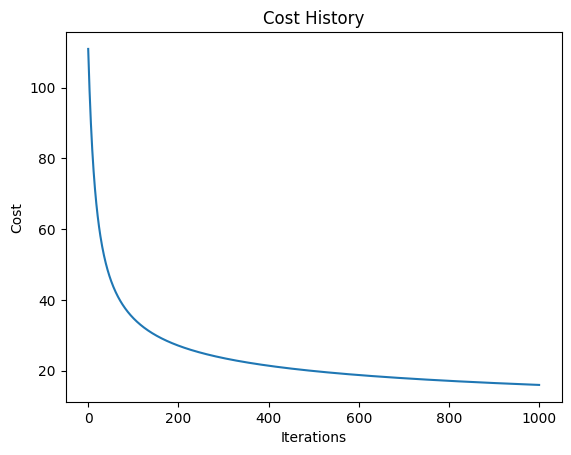

In [124]:
fig = plt.figure()
plt.plot(logReg2.get_cost_hist())
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()
fig.savefig('plots/sgd_cost_hist.png')

In [125]:
sgd_trained_weights = logReg2.get_params()
print(f'Trained Weights: {sgd_trained_weights}')
sgd_cf_info = utilsAC.get_performance_measure(data_y, logReg2.predict(utilsAC.normMinMax(data_x, mode='train')[0]))
sgd_cf_matrix = [[sgd_cf_info['tn'], sgd_cf_info['fn']], [sgd_cf_info['fp'], sgd_cf_info['tp']]]

Trained Weights: [[  1.12321637]
 [-15.27689749]
 [ 11.82227785]]


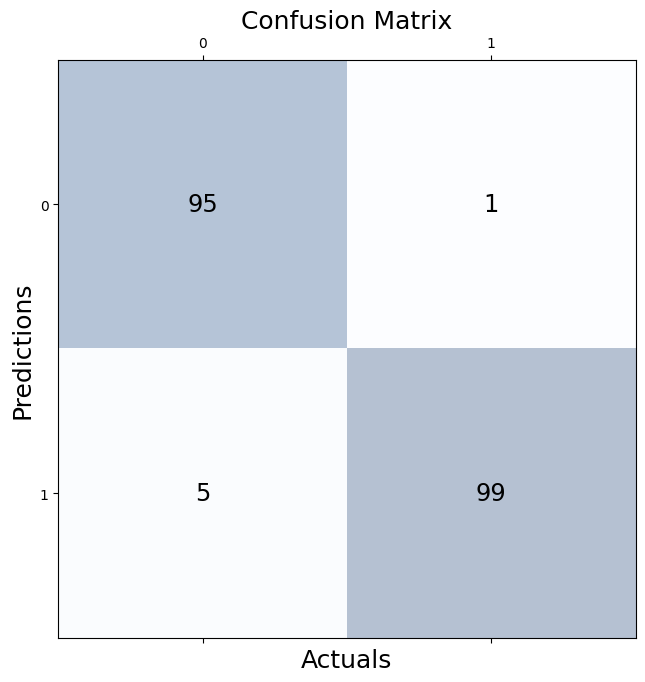

In [126]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(sgd_cf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(len(sgd_cf_matrix)):
    for j in range(len(sgd_cf_matrix[i])):
        ax.text(x=j, y=i,s=sgd_cf_matrix[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Actuals', fontsize=18)
plt.ylabel('Predictions', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig('plots/sgd_confusion_matrix.png')

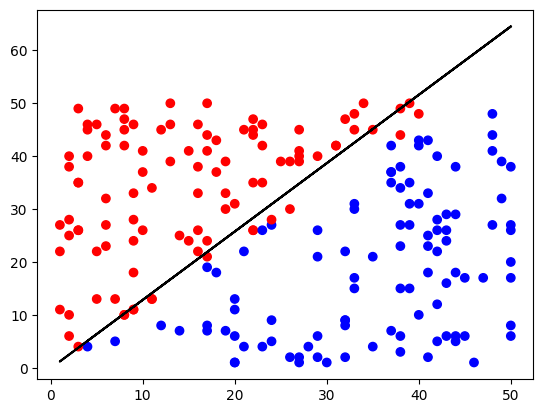

In [127]:
sgd_vals = np.dot(np.c_[np.ones((data_x.shape[0], 1)), data_x], sgd_trained_weights).flatten()
sgd_plot_y = []
for i in range(len(sgd_vals)):
    sgd_plot_y.append(-(sgd_trained_weights[0] + (sgd_trained_weights[1] * data_x.iloc[i, 0])) / sgd_trained_weights[2])
fig = plt.figure()
plt.plot(data_x.iloc[:, 0], sgd_plot_y, c='black')
plt.scatter(data_x.iloc[:, 0], data_x.iloc[:, 1], c=data_y.map({0: 'blue', 1: 'red'}), marker='o')
plt.show()
fig.savefig('plots/sgd_data_dist_db.png')

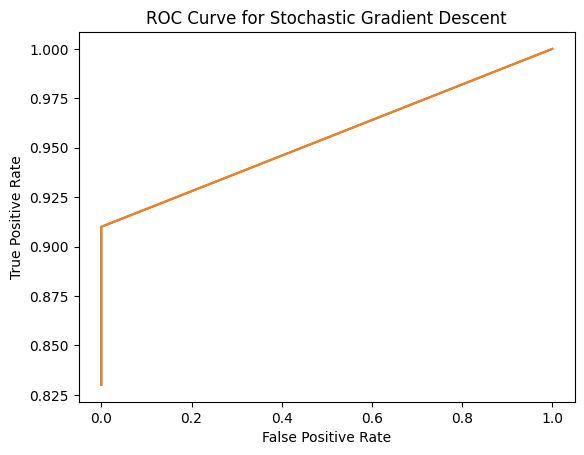

In [128]:
sgd_pred_prob = logReg2.predict(data_x, prob=True)
sgd_tpr = []
sgd_fpr = []
for t in thresh:
    sgd_pred = [1 if i >= t else 0 for i in sgd_pred_prob]
    sgd_cf_info = utilsAC.get_performance_measure(data_y, sgd_pred)
    tp = sgd_cf_info['tp']
    fp = sgd_cf_info['fp']
    tn = sgd_cf_info['tn']
    fn = sgd_cf_info['fn']
    sgd_tpr.append(tp/(tp+fn))
    sgd_fpr.append(fp/(fp+tn))
fig = plt.figure()
plt.plot(sgd_fpr, sgd_tpr)
plt.plot(gd_fpr, gd_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stochastic Gradient Descent')
plt.show()
fig.savefig('plots/sgd_roc.png')